In [1]:
## Importing Libraries

# Python-based Libraries
from datetime import timedelta, datetime
from pathlib import Path
import os

# Data Analysis Libraries
import numpy as np
import pandas as pd

# Graph plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mplcols
from matplotlib import cm
    
# Extract CTD
import ctd

# Filtering Data before Plotting
from scipy import signal

In [2]:

class ctdAnalysis:
    def __init__(self, folderPath):
        self.data = {}
        self.folderPath = folderPath

    def filter_fxn(self, data):
        window = 150
        poly = 7
        filtered_data = signal.savgol_filter(data, window, poly)
    
        return filtered_data

    def extractData(self): #Extracting the data from the CTD file
        #%%
        # self.dataName = {}
        # self.folderName = f"{self.ctdPath}"

        self.data_columns = ["Pressure", "Temperature", "Salinity", "Oxygen"]

        for ctd_file in os.listdir(self.folderPath):
            if ctd_file.endswith(".cnv"):
                data_key = ctd_file.split(".")[0]
                fetched_data = ctd.from_cnv(f'{self.folderPath}/{ctd_file}')
                down_data, up_data = fetched_data.split()
                data_value = {"all":fetched_data, "down":down_data, "up":up_data}

                for df_value_key in data_value:
                    data_value[df_value_key].reset_index(inplace=True) # Removing "Pressure" as the index [now a column].
                    data_value[df_value_key] = data_value[df_value_key].rename({"Pressure [dbar]":"Pressure", 
                                                                                "t090C":"Temperature", "sal00":"Salinity", 
                                                                                "sbeox0V":"Oxygen"}, axis = "columns")
                    data_value[df_value_key] = data_value[df_value_key][ data_value[df_value_key]["flag"]==False ]
                    
                    if df_value_key in ["up", "all"]:
                        # Removing data where the pressure is negative: negative pressure indicates 
                        # that the reading is taken outside the sea
                        data_value[df_value_key] = data_value[df_value_key][ data_value[df_value_key]["Pressure"]>=0 ]
                    
                    # Taking only the needed columns
                    data_value[df_value_key] = data_value[df_value_key][self.data_columns]

                self.data[data_key] = data_value

    #Plotting Pressure against Temperature, Salinity and Oxygen _to see the thermocline, halocline and oxycline_.
    def variationPlot(self, filter=False, plotAll=False): #applies filter if value of filter is true
        self.extractData()
        if not filter:
            fig, ax = plt.subplots(len(self.data), 3, figsize=(13,3*len(self.data)))
            fig.suptitle('Variation of Temperature, Salinity and Oxygen Conentration with Depth')

            for ctd_id, ctd_key in enumerate(self.data):
                
                ctd_df = self.data[ctd_key]
                
                for id_col, col in enumerate(self.data_columns[1:]):

                    if plotAll:
                        ax[ctd_id, id_col].plot(ctd_df["down"][col], ctd_df["down"]["Pressure"], '-b',
                                        ctd_df["up"][col], ctd_df["up"]["Pressure"], '-r')

                        ax[ctd_id, id_col].set(ylim=[max(ctd_df["all"]['Pressure']), 0])
                        ax[ctd_id, id_col].set(xlabel=col, ylabel=f'Pressure, Station {ctd_key}')
                        ax[ctd_id, id_col].grid()
                        ax[ctd_id, id_col].locator_params(nbins=7, axis="x")
                        ax[ctd_id, id_col].legend(["down", "up"])

                    else:
                        ax[ctd_id, id_col].plot(ctd_df["down"][col], ctd_df["down"]["Pressure"])

                        ax[ctd_id, id_col].set(ylim=[max(ctd_df["down"]['Pressure']), 0])
                        ax[ctd_id, id_col].set(xlabel=col, ylabel=f'Pressure, Station {ctd_key}')
                        ax[ctd_id, id_col].grid()
                        ax[ctd_id, id_col].locator_params(nbins=7, axis="x")
                        # ax[ctd_id, id_col].legend(["down", "up"])

                    

            fig.tight_layout()
            plt.show()
        else:
            fig, ax = plt.subplots(len(self.data), 3, figsize=(13, 3*len(self.data)))
            fig.suptitle('Variation of Temperature, Salinity and Oxygen Conentration with Depth\n(Filtered Plot)')

            for ctd_id, ctd_key in enumerate(self.data):
                
                ctd_df = self.data[ctd_key]
                
                for id_col, col in enumerate(self.data_columns[1:]):
                    if plotAll:
                        ax[ctd_id, id_col].plot(self.filter_fxn(ctd_df["down"][col]), self.filter_fxn(ctd_df["down"]["Pressure"]), '-b',
                                        self.filter_fxn(ctd_df["up"][col]), self.filter_fxn(ctd_df["up"]["Pressure"]), '-r')
                        
                        ax[ctd_id, id_col].set(ylim=[max(ctd_df["all"]['Pressure']), 0])
                        ax[ctd_id, id_col].set(xlabel=col, ylabel=f'Pressure, Station {ctd_key}')
                        ax[ctd_id, id_col].grid()
                        ax[ctd_id, id_col].locator_params(nbins=7, axis="x")
                        ax[ctd_id, id_col].legend(["down", "up"])

                    else:
                        ax[ctd_id, id_col].plot(self.filter_fxn(ctd_df["down"][col]), self.filter_fxn(ctd_df["down"]["Pressure"]))
                        
                        ax[ctd_id, id_col].set(ylim=[max(ctd_df["down"]['Pressure']), 0])
                        ax[ctd_id, id_col].set(xlabel=col, ylabel=f'Pressure, Station {ctd_key}')
                        ax[ctd_id, id_col].grid()
                        ax[ctd_id, id_col].locator_params(nbins=7, axis="x")
                        # ax[ctd_id, id_col].legend(["down", "up"])
                    
            fig.tight_layout()
            plt.show()

    #Plotting of Pressure against Temperature, Salinity and Oxygen (over the same range of axis)
    def variationPlotSameRange(self, plotAll=False):
        self.extractData()
        fig, ax = plt.subplots(len(self.data), 3, figsize=(13,3*len(self.data)), sharex='col')
        fig.suptitle('Variation of Temperature, Salinity and Oxygen Conentration with Depth\n(Same Axis Range)')
        # plt.locator_params(axis='x', nbins=6)

        for ctd_id, ctd_key in enumerate(self.data):
            
            ctd_df = self.data[ctd_key]
            
            for id_col, col in enumerate(self.data_columns[1:]):
                if plotAll:
                    ax[ctd_id, id_col].plot(ctd_df["down"][col], ctd_df["down"]["Pressure"], '-b',
                                    ctd_df["up"][col], ctd_df["up"]["Pressure"], '-r')

                    ax[ctd_id, id_col].set(ylim=[max(ctd_df["all"]['Pressure']), 0])
                    ax[ctd_id, id_col].set(xlabel=col, ylabel=f'Pressure, Station {ctd_key}')
                    ax[ctd_id, id_col].grid()
                    ax[ctd_id, id_col].locator_params(nbins=7, axis="x")
                    ax[ctd_id, id_col].legend(["down", "up"])

                else:
                    ax[ctd_id, id_col].plot(ctd_df["down"][col], ctd_df["down"]["Pressure"])

                    ax[ctd_id, id_col].set(ylim=[max(ctd_df["down"]['Pressure']), 0])
                    ax[ctd_id, id_col].set(xlabel=col, ylabel=f'Pressure, Station {ctd_key}')
                    ax[ctd_id, id_col].grid()
                    ax[ctd_id, id_col].locator_params(nbins=7, axis="x")
                    # ax[ctd_id, id_col].legend(["down", "up"])

        fig.tight_layout()
        plt.show()

    #PLOT THE T-S PROFILE
    def TSPlot(self, filter=False, plotAll=False):
        self.extractData()
        if not filter:
            fig, ax = plt.subplots(2, 2, figsize=( 10, 5*len(self.data)/2 ))
            fig.suptitle('Temperature-Salinity Diagram of Each Station')

            for ctd_id, ctd_key in enumerate(self.data):
                
                # Brief Manipulation to obtain the position on the subplot
                if ctd_id < 2: 
                    x_ind = 0
                    y_ind = ctd_id % 2
                else:
                    x_ind = 1
                    y_ind = ctd_id % 2
                
                ctd_df = self.data[ctd_key]
                
                if plotAll:
                    ax[x_ind, y_ind].scatter(ctd_df["down"]["Salinity"], ctd_df["down"]["Temperature"], facecolors='none', edgecolors ='b')
                    ax[x_ind, y_ind].scatter(ctd_df["up"]["Salinity"], ctd_df["up"]["Temperature"], facecolors='none', edgecolors ='r')
                    
                    ax[x_ind, y_ind].set(xlabel="Salinity", ylabel='Temperature', title=f"Station {ctd_key}")
                    ax[x_ind, y_ind].grid()
                    ax[x_ind, y_ind].locator_params(nbins=7, axis="x")
                    ax[x_ind, y_ind].legend(["down", "up"])

                else:
                    ax[x_ind, y_ind].scatter(ctd_df["down"]["Salinity"], ctd_df["down"]["Temperature"])
                    
                    ax[x_ind, y_ind].set(xlabel="Salinity", ylabel='Temperature', title=f"Station {ctd_key}")
                    ax[x_ind, y_ind].grid()
                    ax[x_ind, y_ind].locator_params(nbins=7, axis="x")
                    # ax[x_ind, y_ind].legend(["down", "up"])


            fig.tight_layout()
            plt.show()

        else:
            fig, ax = plt.subplots(2, 2, figsize=( 10, 5*len(self.data)/2 ))
            fig.suptitle('Temperature-Salinity Diagram of Each Station\n(Filtered Data)')

            for ctd_id, ctd_key in enumerate(self.data):
                
                # Brief Manipulation to obtain the position on the subplot
                if ctd_id < 2: 
                    x_ind = 0
                    y_ind = ctd_id % 2
                else:
                    x_ind = 1
                    y_ind = ctd_id % 2
                
                ctd_df = self.data[ctd_key]
                
                if plotAll:
                    ax[x_ind, y_ind].scatter(self.filter_fxn(ctd_df["down"]["Salinity"]), self.filter_fxn(ctd_df["down"]["Temperature"]), facecolors='none', edgecolors ='b')

                    ax[x_ind, y_ind].scatter(self.filter_fxn(ctd_df["up"]["Salinity"]), self.filter_fxn(ctd_df["up"]["Temperature"]), facecolors='none', edgecolors ='r')
                    
                    ax[x_ind, y_ind].set(xlabel="Salinity", ylabel='Temperature', title=f"Station {ctd_key}")
                    ax[x_ind, y_ind].grid()
                    ax[x_ind, y_ind].locator_params(nbins=7, axis="x")
                    ax[x_ind, y_ind].legend(["down", "up"])

                else:
                    ax[x_ind, y_ind].scatter(self.filter_fxn(ctd_df["down"]["Salinity"]), self.filter_fxn(ctd_df["down"]["Temperature"]))
                    
                    ax[x_ind, y_ind].set(xlabel="Salinity", ylabel='Temperature', title=f"Station {ctd_key}")
                    ax[x_ind, y_ind].grid()
                    ax[x_ind, y_ind].locator_params(nbins=7, axis="x")


            fig.tight_layout()
            plt.show()
            
            
        

HOW TO USE

- pass the path to the folder
- call the variationPlot method 
    - default is to no filter and no plotting for up and down
    - to activate filters, set Filter = True
    - to activate both plot, set plotAll = True
- call the TSPlot method
    - default is to no filter and no plotting for up and down
    - to activate filters, set Filter = True
    - to activate both plot, set plotAll = True

#################### DAY ONE ################


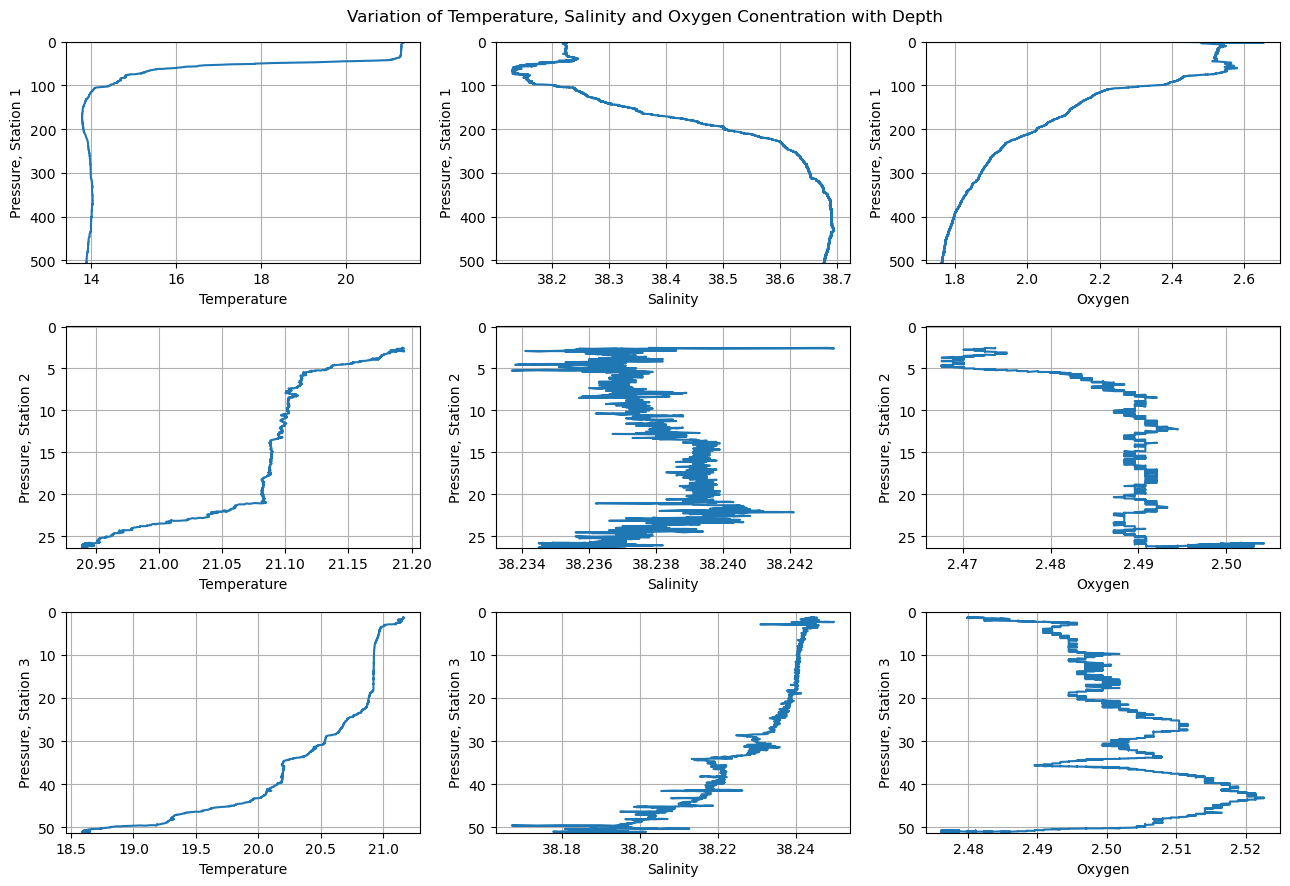

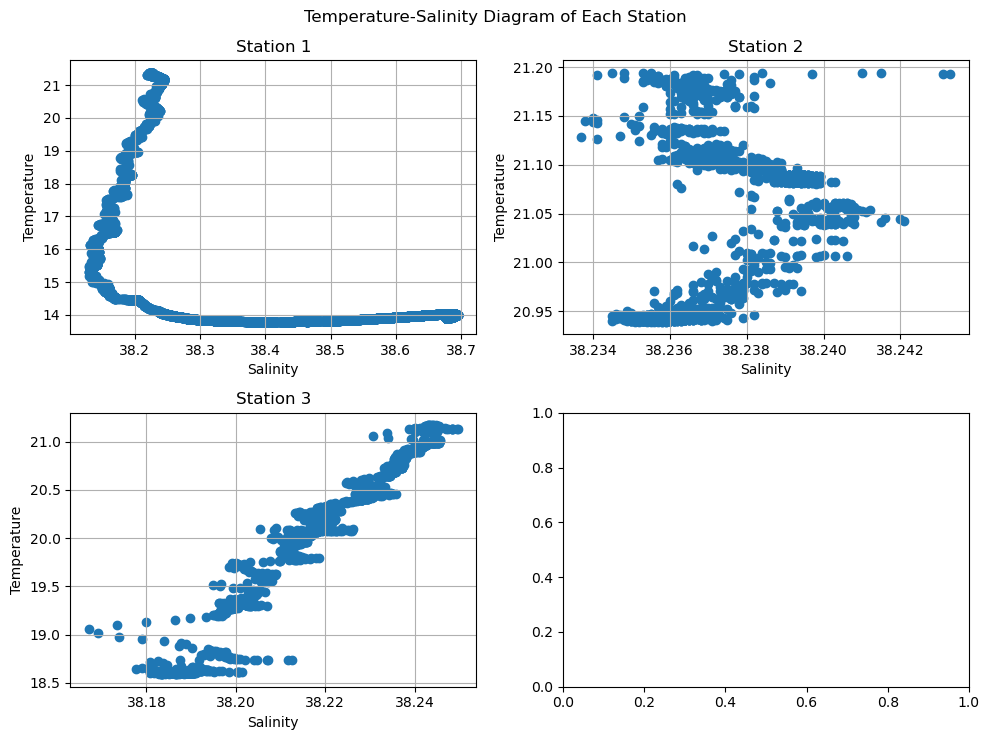

In [3]:
print('#################### DAY ONE ################')
dayOne = ctdAnalysis('Data/2022/Day1/ctds')
dayOne.variationPlot(plotAll=False)
dayOne.TSPlot(plotAll=False)

#################### DAY TWO ################


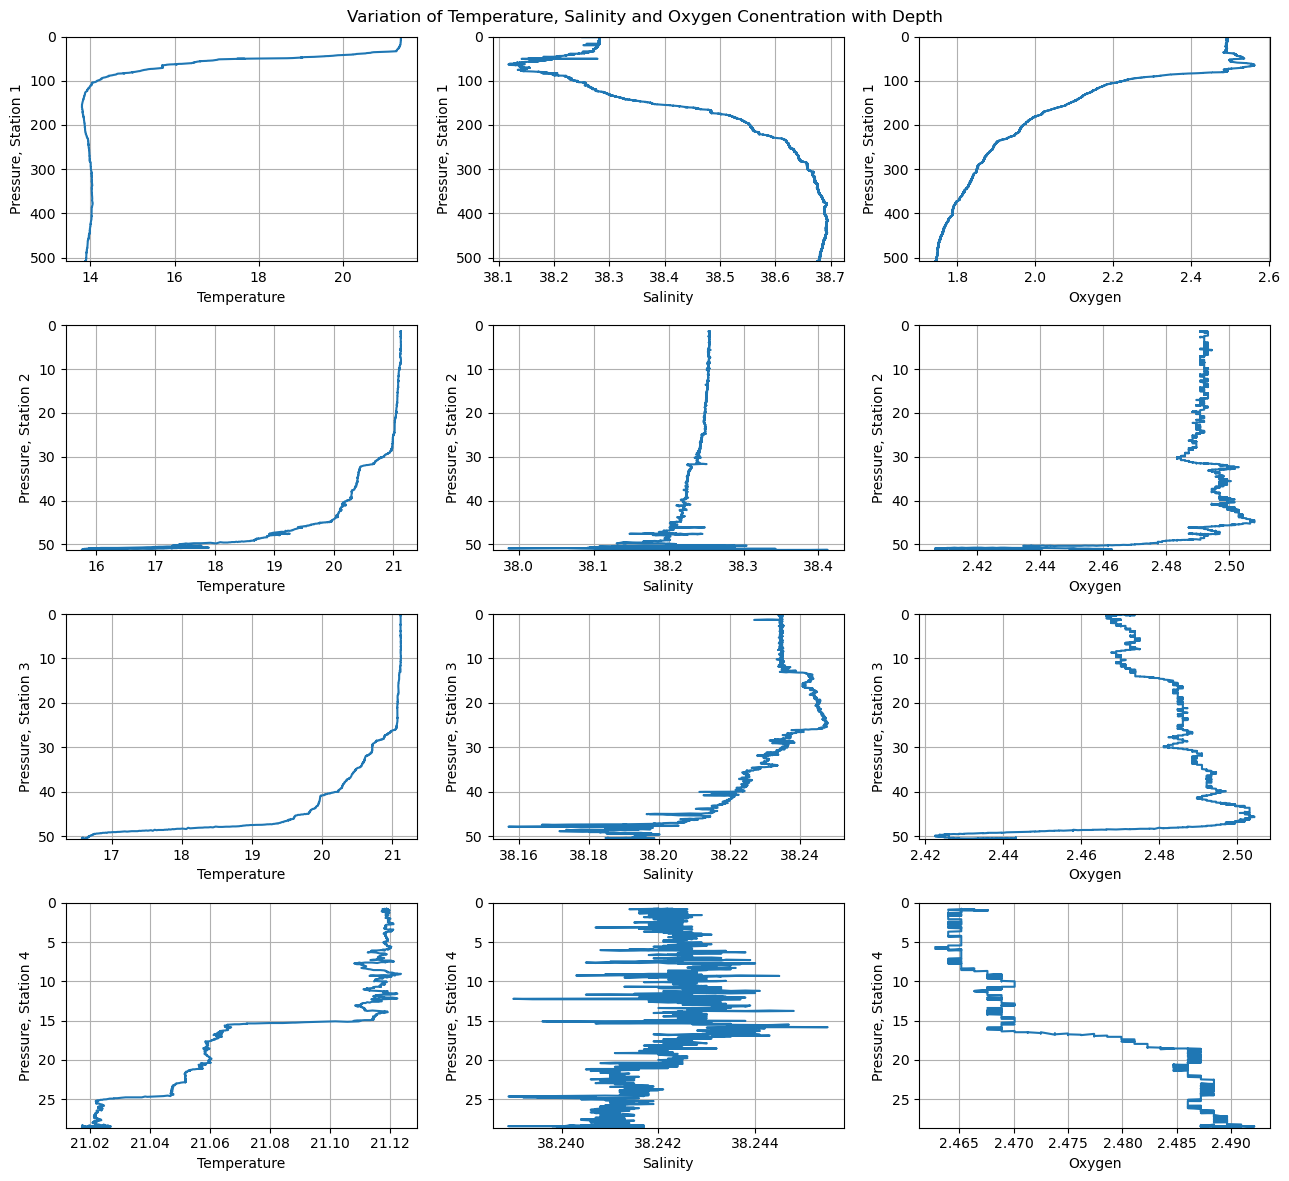

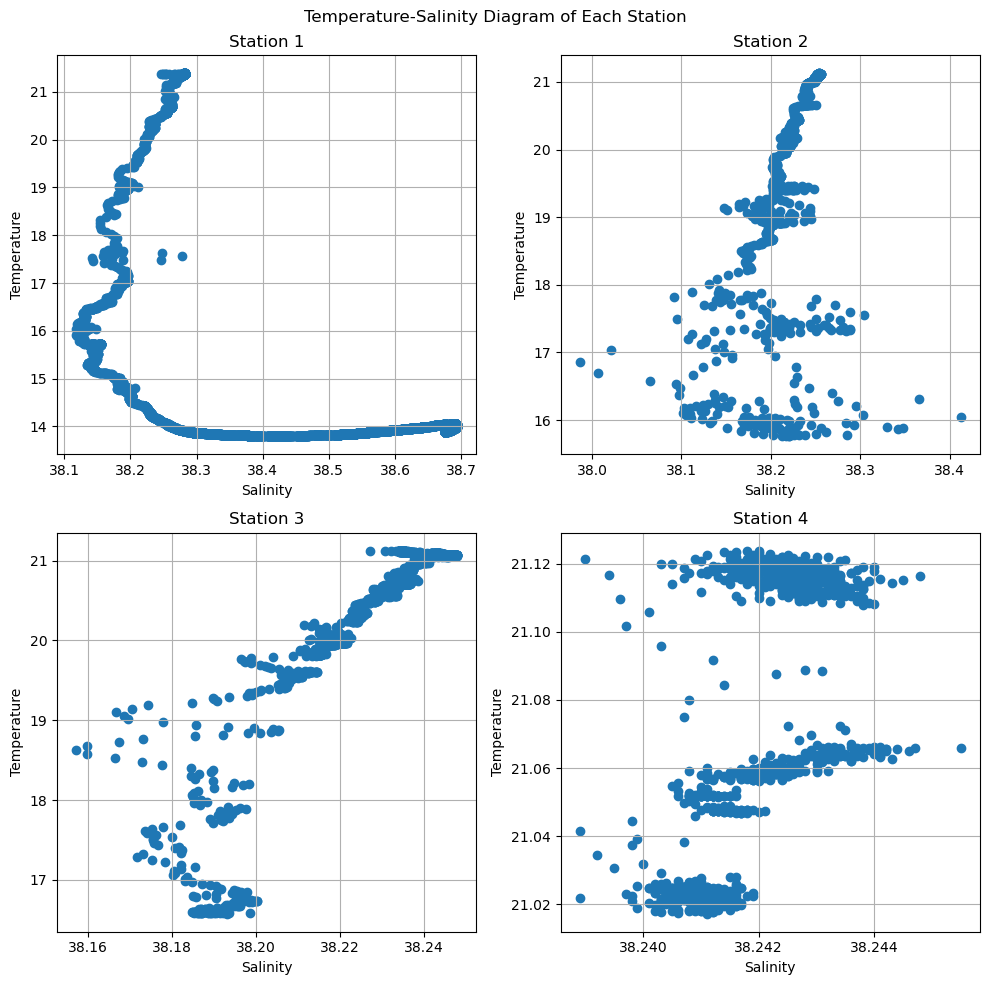

In [4]:
print('#################### DAY TWO ################')
dayTwo = ctdAnalysis('Data/2022/Day2/ctds')
dayTwo.variationPlot()
dayTwo.TSPlot()

#################### DAY THREE ################


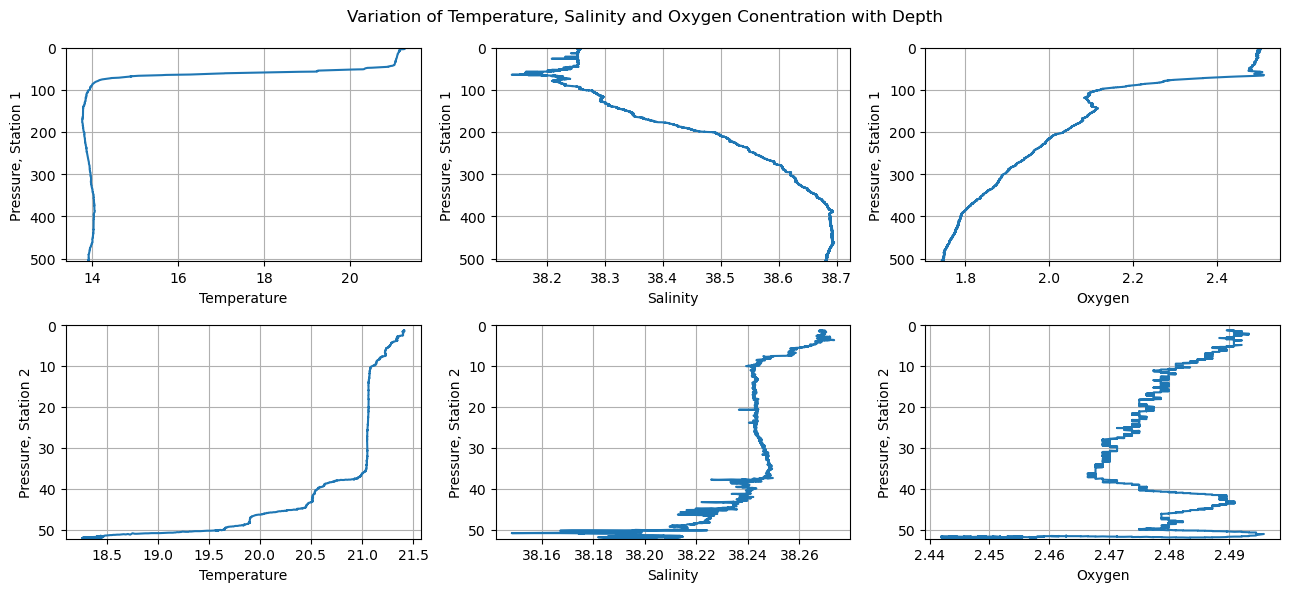

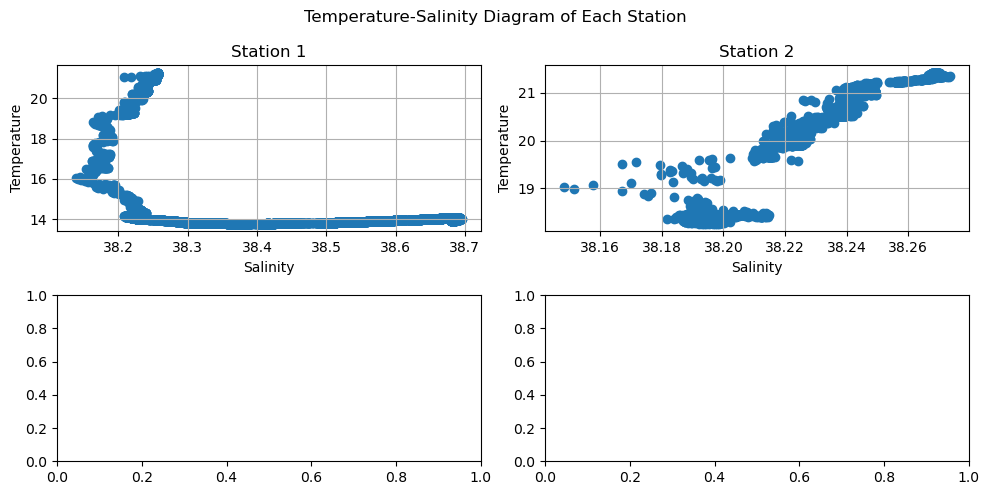

In [5]:
print('#################### DAY THREE ################')
dayThree = ctdAnalysis('Data/2022/Day3/ctds')
dayThree.variationPlot()
dayThree.TSPlot()